In [43]:
from utils.datasets import RetroEditDataset, RetroEvalDataset
import torch
import joblib
from rdkit import Chem
import copy
from typing import Any, Tuple
from utils.rxn_graphs import MolGraph, RxnGraph, Vocab
from utils.collate_fn import get_batch_graphs, prepare_edit_labels
from utils.reaction_actions import (AddGroupAction, AtomEditAction,
                                    BondEditAction, Termination)
from utils.mol_features import ATOM_FDIM, BOND_FDIM
from models import Graph2Edits
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [44]:
def apply_edit_to_mol(mol: Chem.Mol, edit: Tuple, edit_atom: Any) -> Chem.Mol:
    """ Apply edits to molecular graph """

    if edit[0] == 'Change Atom':
        edit_exe = AtomEditAction(
            edit_atom, *edit[1], action_vocab='Change Atom')
        new_mol = edit_exe.apply(mol)

    if edit[0] == 'Delete Bond':
        edit_exe = BondEditAction(
            *edit_atom, *edit[1], action_vocab='Delete Bond')
        new_mol = edit_exe.apply(mol)

    if edit[0] == 'Change Bond':
        edit_exe = BondEditAction(
            *edit_atom, *edit[1], action_vocab='Change Bond')
        new_mol = edit_exe.apply(mol)

    if edit[0] == 'Add Bond':
        edit_exe = BondEditAction(
            *edit_atom, *edit[1], action_vocab='Add Bond')
        new_mol = edit_exe.apply(mol)

    if edit[0] == 'Attaching LG':
        edit_exe = AddGroupAction(
            edit_atom, edit[1], action_vocab='Attaching LG')
        new_mol = edit_exe.apply(mol)

    return new_mol

In [45]:
a=torch.load("./data/uspto_50k/train/without_rxn_class/batch-0.pt")
b=torch.load("./data/uspto_50k/train/without_rxn_class/batch-1.pt")

FileNotFoundError: [Errno 2] No such file or directory: './data/uspto_50k/train/without_rxn_class/batch-0.pt'

In [ ]:
train_dir="./data/uspto_50k/train/without_rxn_class/"
train_dataset = RetroEditDataset(data_dir=train_dir)
train_data = train_dataset.loader(
        batch_size=1, num_workers=0, shuffle=True)

In [ ]:
for batch_id, batch_data in enumerate(train_data):
        graph_seq_tensors, seq_labels, seq_mask = batch_data
        break

In [ ]:
graph_seq_tensors[0][0][0].shape

torch.Size([856, 85])

In [ ]:
datafile = f'data/uspto_50k/train/train.file.kekulized'
rxns_data = joblib.load(datafile)
batch_graphs = []
batch_num=0
for idx, rxn_data in enumerate(rxns_data[0:32]):
    graph_seq = []
    rxn_smi = rxn_data.rxn_smi
    r, p = rxn_smi.split('>>')
    r_mol = Chem.MolFromSmiles(r)
    p_mol = Chem.MolFromSmiles(p)
    Chem.Kekulize(p_mol)
    int_mol=p_mol
    int_list=[]
    for i, edit in enumerate(rxn_data.edits):
        
        if int_mol is None:
            print("Interim mol is None")
            break
        if edit == 'Terminate':
            graph = RxnGraph(prod_mol=Chem.Mol(
                int_mol), edit_to_apply=edit, reac_mol=Chem.Mol(r_mol), rxn_class=rxn_data.rxn_class, use_rxn_class=False)
            graph_seq.append(graph)
            edit_exe = Termination(action_vocab='Terminate')
            try:
                pred_mol = edit_exe.apply(Chem.Mol(int_mol))
                final_smi = Chem.MolToSmiles(pred_mol)
            except Exception as e:
                final_smi = None
        else:
            graph = RxnGraph(prod_mol=Chem.Mol(int_mol), edit_to_apply=edit,
                                edit_atom=rxn_data.edits_atom[i], reac_mol=Chem.Mol(r_mol), rxn_class=rxn_data.rxn_class, use_rxn_class=False)
            graph_seq.append(graph)
            int_mol = apply_edit_to_mol(
                Chem.Mol(int_mol), edit, rxn_data.edits_atom[i])


    batch_graphs.append(graph_seq)

In [ ]:
lengths = torch.tensor([len(graph_seq)
                        for graph_seq in batch_graphs], dtype=torch.long)
max_length = max([len(graph_seq) for graph_seq in batch_graphs])

bond_vocab_file = f'data/uspto_50k/train/bond_vocab.txt'
atom_vocab_file = f'data/uspto_50k/train/atom_lg_vocab.txt'
bond_vocab = Vocab(joblib.load(bond_vocab_file))
atom_vocab = Vocab(joblib.load(atom_vocab_file))

graph_seq_tensors = []
edit_seq_labels = []
seq_mask = []


In [ ]:
for idx in range(max_length):
    graphs_idx = [copy.deepcopy(batch_graphs[i][min(idx, length-1)]).get_components(attrs=['prod_graph', 'edit_to_apply', 'edit_atom'])
                    for i, length in enumerate(lengths)]
    mask = (idx < lengths).long()
    prod_graphs, edits, edit_atoms = list(zip(*graphs_idx))
    assert all([isinstance(graph, MolGraph) for graph in prod_graphs])

    edit_labels = prepare_edit_labels(
        prod_graphs, edits, edit_atoms, bond_vocab, atom_vocab)
    current_graph_tensors = get_batch_graphs(
        prod_graphs, use_rxn_class=False)

    graph_seq_tensors.append(current_graph_tensors)
    edit_seq_labels.append(edit_labels)
    seq_mask.append(mask)
    break

In [ ]:
data_dir = os.path.join("./", 'data', 'uspto_50k', 'test')
test_file = os.path.join(data_dir, 'test.file.kekulized')
test_data = joblib.load(test_file)
p_bar = tqdm(list(range(len(test_data))))

In [ ]:
class_num=[0]*10
for idx in p_bar:
    rxn_data = test_data[idx]
    rxn_class=rxn_data.rxn_class
    class_num[rxn_class]+=1
    if class_num[rxn_class]>100:
        break

In [ ]:
class_num

[101, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
class_num

[150, 149, 149, 150, 150, 150, 150, 150, 1, 150]

In [ ]:
class_num

[150, 149, 149, 150, 150, 150, 150, 150, 1, 150]

In [56]:
accuary_list=[0.473333,0.63333,0.463087,0.456376,0.693333,0.606667,0.540000,0.513333,0.413333,0.7516780]


In [53]:
train_sample=train_data["class"].value_counts()
train_sample_list=train_sample.sort_index().tolist()

Text(0.5, 1.0, 'accuary for each class')

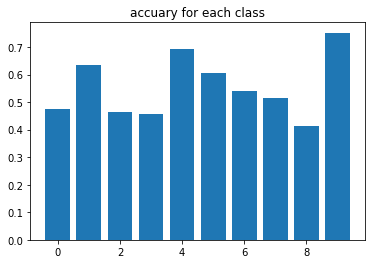

In [62]:
plt.bar(range(10),accuary_list)
plt.title("accuary for each class")

Text(0.5, 1.0, 'number of samples for each class in train dataset')

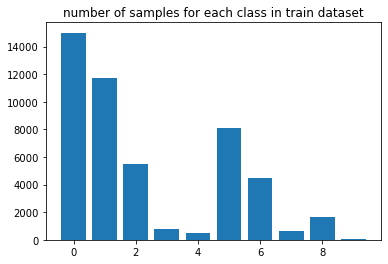

In [63]:
plt.bar(range(10),train_sample_list)
plt.title("number of samples for each class in train dataset")

In [24]:
train_data=pd.read_csv("./data/uspto_50k/canonicalized_lt_train.csv")
train_data["class"].value_counts()

1     15001
2     11746
6      8087
3      5512
7      4464
9      1684
4       759
8       661
5       522
10       80
Name: class, dtype: int64

In [47]:
200%100==0

True

In [113]:
atom_fdim = ATOM_FDIM
f_atoms = [[0] * atom_fdim]

In [123]:
f_atoms.extend(mol_graph.f_atoms)

In [128]:
mol_graph.n_bonds

54

In [56]:
    bond_vocab_file = f'data/uspto_50k/train/bond_vocab.txt'
    atom_vocab_file = f'data/uspto_50k/train/atom_lg_vocab.txt'
    bond_vocab = Vocab(joblib.load(bond_vocab_file))
    atom_vocab = Vocab(joblib.load(atom_vocab_file))


In [69]:
batch_graphs=[]
batch_graphs.append(graph_seq)
batch_graphs.append(graph_seq)
lengths = torch.tensor([len(graph_seq)
                        for graph_seq in batch_graphs], dtype=torch.long)
graphs_idx = [copy.deepcopy(batch_graphs[i][min(0, length-1)]).get_components(attrs=['prod_graph', 'edit_to_apply', 'edit_atom'])
                      for i, length in enumerate(lengths)]

In [136]:
def build_model_config():
    model_config = {}
    atom_fdim = ATOM_FDIM + 10
    model_config['n_atom_feat'] = atom_fdim
    model_config['n_bond_feat'] = BOND_FDIM
    model_config['mpn_size'] = 512
    model_config['mlp_size'] = 512
    model_config['depth'] = 10
    model_config['dropout_mlp'] = 0.2
    model_config['dropout_mpn'] = 0.15
    model_config['atom_message'] = False
    model_config['use_attn'] = False
    model_config['n_heads'] = 8

    return model_config


model_config = build_model_config()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [137]:
model=Graph2Edits(config=model_config, atom_vocab=atom_vocab,
                        bond_vocab=bond_vocab, device=DEVICE)

In [140]:
a_feats = model.encoder(graph_seq_tensors[0], mask=None)

ValueError: not enough values to unpack (expected 6, got 2)

In [143]:
len(graph_seq_tensors)

1

In [75]:
prod_graphs, edits, edit_atoms = list(zip(*graphs_idx))

In [81]:
edit_labels = prepare_edit_labels(
            prod_graphs, edits, edit_atoms, bond_vocab, atom_vocab)
current_graph_tensors = get_batch_graphs(
    prod_graphs, use_rxn_class=False)

In [85]:
edit_labels

[tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64),
 tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)]

In [103]:
prod_graphs, edits, edit_atoms = list(zip(*graphs_idx))

In [1]:
import os
from utils.rxn_graphs import Vocab
import joblib
atom_vocab_file = f'./data/uspto_50k/train/atom_vocab.txt'
atom_vocab = Vocab(joblib.load(atom_vocab_file))

RDKit WARNING: [13:20:58] Enabling RDKit 2019.09.2 jupyter extensions
